In [162]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import random
import itertools
import math

## Un + Weighted Maxcut Graph Generator

In [163]:
def G(n, seed, probability, sparse=True, w=None, r=True):
    """
    Generates a seeded random graph with n nodes. 
    probability between 0 and 1 to increase odds.
    sparse means if we want a sparse or dense graph.
    w is the weight of the edges if wanted.
    r means if we want random weights or not.
    """
    random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i, j in itertools.combinations(G.nodes, 2):
        if sparse == True:
            if random.random() > (1 - probability):
                if r == True:
                    G.add_edge(i, j, weight=random.random())
                else:
                    G.add_edge(i, j, weight=w)
        if sparse == False:
            #Means we want a dense network, so
            if r == True:
                G.add_edge(i, j, weight=random.random())
            else:
                G.add_edge(i, j, weight=w)
    return G

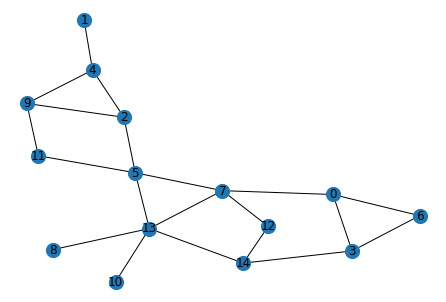

In [216]:
def plot_network(G):
    """
    Plots the graph G.
    """
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=200)
    if len(G.nodes) < 10:
            edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.show()

GG = G(15, random.random(), 0.20, sparse=True, w=1, r=False)
plot_network(GG)

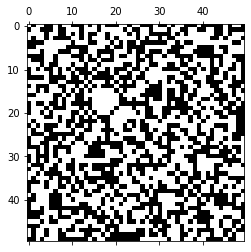

In [174]:
GG = G(50, random.random(), 0.5, sparse=True, w=1, r=False)
adjacency = nx.adjacency_matrix(GG).todense()
# Adjacency is equivalent to the Q matrix in the paper.
plt.spy(adjacency)
# Check if Q is symmetric
Q = adjacency
assert(Q.all() == (Q.T).all())

In [217]:
# Objective function as in the paper.
f = lambda x, Q, b: -1/2 * (x.T @ Q @ x) + (b.T @ x)

In [224]:
# Function to calculate the maximum cut of the graph
def maxcut(Q, b, treshhold=0.04,alpha=0.1, tol=0.001, max_iter=1000, g_norm=1):
    """
    Q is the dense adjacency matrix of the graph.
    b is the vector of the biases.
    We are initializing our first choice of x to be all 1s. 
    alpha is the learning rate.
    tol is the tolerance for the stopping condition.
    max_iter is the maximum number of iterations.
    g_norm is the norm of the gradient.
    """
    # X matrix needs start all -1 or 1 to be consistent with the paper.
    x = np.ones(Q.shape)
    # Initialize the value of the objective function
    f_x = f(x, Q, b)
    # Empty gradient
    g_x = np.zeros(Q.shape[0])
    # Empty Hessian
    H_x = np.zeros(Q.shape[0])
    # Gradient norm
    g_norm = 1
    # Step size
    k = 0
    # Iterate until the gradient norm is less than the tolerance
    while g_norm > tol and k < max_iter:
        # Update the value of the gradient and its norm
        g_x = (Q @ x) + b
        g_norm = np.linalg.norm(g_x)
        # Update the value of the Hessian (unused)
        H_x = Q + np.diag(x)
        # Step size based on the norm
        alpha = 1/(g_norm**2)

        # Hopfield network update rule with treshhold
        # Treating the gradient times the learning rate 
        # as the weight between nodes in the network.
        
        # flipper is analogous to the weights in hopfield network.

        flipper = g_x * alpha
        #flipper = Q

        for i in range(len(flipper)):
            for j in range(len(flipper)):
                if flipper.item(i, j)*x[i,j] >= treshhold:
                    x[i,j] = 1
                else:
                    x[i,j] = -1    

        # Update the value of the objective function
        f_x = f(x, Q, b)
        # Update the value of the iteration
        k += 1
    return x, f_x

In [225]:
GG = G(10, 1, 0.5, sparse=True, w=1, r=False)
adjacency = nx.adjacency_matrix(GG).todense()
b = np.zeros(GG.number_of_nodes())
Q = adjacency
x, f_x = maxcut(Q, b,treshhold=0.003,max_iter=1000)
# Diagonals are whether the nodes should be in one graph or the other.
# If they are in one graph, they are -1, if they are in the other graph, they are 1.

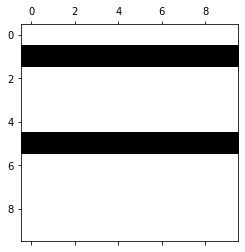

In [226]:
plt.spy((x + 1))
#flipper = Q inside of maxcut()
#makes the network store Q as the pattern?

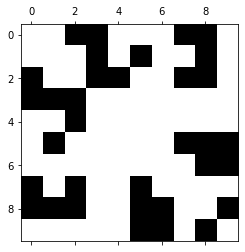

In [227]:
plt.spy(Q)

In [228]:
def plot_maxcut_on_network(G, x):
    """
    Plots the maximum cut of a graph on a network plot.
    """
    # Plot the maximum cut as node states, and the state of the nodes as node colors
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=200)
    #Update the node colors based on the dense adjacency matrix
    node_colors = []
    for i in range(len(x)):
        if x[i,i] == -1:
                node_colors.append('red')
        else:
                node_colors.append('blue')
    nx.draw_networkx_nodes(G, pos, nodelist=range(len(x)), node_color=node_colors, node_size=200)    
    # Display the edge values (for toy problems)
    if len(G.nodes) < 10:
            edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.show()


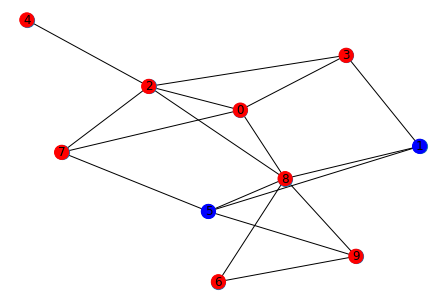

In [229]:
plot_maxcut_on_network(GG, x)

In [232]:
#Solving via brute force
n = 10
w = Q
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 4
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 5
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 8
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 10
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 3
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 5
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 4
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 7
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 1
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 5
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 4
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 8
case = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0] cost = 4
case = [1, 0

In [ ]:
# This network result 1000100000 (cost 5)
# Not equal to QAOA result of 0111111001 (cost 9)
# Nor of the brute force of 1110011000 (cost 14)